In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision as tv

In [ ]:
#https://pytorch.org/vision/main/models.html

In [ ]:
!wget https://cdn.ngetnews.com/news/photo/202005/301734_12608_1735.jpg -O test.jpg

--2023-08-18 01:53:46--  https://cdn.ngetnews.com/news/photo/202005/301734_12608_1735.jpg
Resolving cdn.ngetnews.com (cdn.ngetnews.com)... 1.224.180.182
Connecting to cdn.ngetnews.com (cdn.ngetnews.com)|1.224.180.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79617 (78K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  77.75K  70.5KB/s    in 1.1s    

2023-08-18 01:53:49 (70.5 KB/s) - ‘test.jpg’ saved [79617/79617]



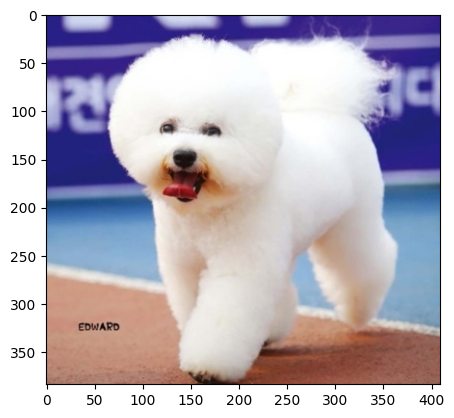

In [ ]:
# read_image 테스트 -> 결과 RGB임이 밝혀졌다..?
from torchvision.io import read_image
img = read_image("test.jpg")
plt.imshow(img.permute(1, 2, 0)) #plt.imshow는 rgb로 영상을 해석하는데, 영상이 이쁘게 잘 나옴 -> RGB임.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Step 1: Initialize model with the best available weights
# weights = ResNet50_Weights.DEFAULT
weights = tv.models.RegNet_X_400MF_Weights.DEFAULT
#model = resnet50(weights=weights)
model = tv.models.regnet_x_400mf(weights)
model = model.eval()

# 여기까지는 예제 코드를 regnet으로 변경

In [ ]:
# 예제 코드에 있는대로 실행해봤는데..
preprocess = weights.transforms()
batch = preprocess(img)
batch.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

In [ ]:
# 여기서 preprocess가 뭔지 echo를 보니까..
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# 1.
image = cv2.imread('test.jpg') #HWC, BGR, uint8(0-255)
image = torch.tensor(image)
image = image[..., [2, 1, 0]] #BGR->RGB
image = image.permute(2, 0, 1) #HWC -> CHW

#제공해주는 함수를 사용
batch = preprocess(image) #resize, scale

# 2. 직접 하려고 하면..
image = cv2.imread('test.jpg') #HWC, BGR, uint8(0-255)
image = cv2.resize(image, (224, 224))
image = torch.tensor(image)
image = image[..., [2, 1, 0]] #BGR->RGB
image = (image/255 - torch.tensor([0.485, 0.456, 0.406])) / torch.tensor([0.229, 0.224, 0.225])
image = image.permute(2, 0, 1) #HWC -> CHW
image.max()

#..................................................
#CHW -> NCHW로 변경, unsqueeze와 똑같음.
batch = image[None]
#모델에 통과시킴
logit = model(batch) #1, 1000
#N, F -> F 크기로 바꾸고, softmax
prob = logit.squeeze(0).softmax(0) # 1000으로 만들고, 확률로 바꾸고
class_id = prob.argmax().item() #최대값의 위치를 찾는다.

score = prob[class_id].item()
weights.meta['categories'][class_id], class_id

('miniature poodle', 266)

# 본격적으로 시작

## 모델 생성.. 그리로 전처리 함수까지

In [ ]:
#기본 불러오기
weights = tv.models.RegNet_X_400MF_Weights.DEFAULT
model = tv.models.regnet_x_400mf(weights=weights)
preprocess = weights.transforms()

#head부분 커스터마이징
model.fc = nn.Linear(400, 4)
dummy = torch.randn(32, 3, 224, 224)
model(dummy).shape

torch.Size([32, 4])

## 이미지 정리

In [ ]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip

--2023-08-18 00:21:33--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.68.18, 52.218.117.34, 52.218.88.48, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.68.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  18.7MB/s    in 5.4s    

2023-08-18 00:21:38 (16.9 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [ ]:
!unzip -qq 4drtyfjtfy-1.zip
!unzip -qq dataset2.zip


In [ ]:
# if i== 1:
# if i == 2:
# if i == 3:
for i in range(10):
    if i == 13:
        break
else:
    print('???')

???


In [ ]:
!rm -rf train
!rm -rf valid

In [ ]:
# 크롤링... 등등으로 이미지 받으면
# 이미지에 대한 검증!
import os
import random

os.makedirs('weather/train', exist_ok=True)
os.makedirs('weather/valid', exist_ok=True)

for root, dirs, filenames in os.walk('dataset2'):
    for filename in filenames:
        path = os.path.join(root, filename)
        image = cv2.imread(path)
        if image is None:
            print('error', path)
            continue

        if image.shape[1] > 1000:
            h = image.shape[0] / image.shape[1] * 1000
            image = cv2.resize(image, (1000, int(h)))

        if random.random() < 0.9:
            dst_path = 'weather/train/' + filename
        else:
            dst_path = 'weather/valid/' + filename

        cv2.imwrite(dst_path, image)

error dataset2/shine131.jpg
error dataset2/rain141.jpg


In [ ]:
!tar -cf drive/MyDrive/weather.tar weather
# !mv weather.tar drive/MyDrive

## 정리된 이미지 불러오기



In [ ]:
!tar -xf drive/MyDrive/weather.tar -C .

## dataset 생성

In [ ]:
import os
import random

dataset_train = []
dataset_valid = []
labels = ['cloudy', 'rain', 'shine', 'sunrise']

for root, dirs, filenames in os.walk('weather'):
    if 'train' in root:
        dataset = dataset_train
    elif 'valid' in root:
        dataset = dataset_valid
    else:
        continue

    for filename in filenames:
        cat = -1
        for i, label in enumerate(labels):
            if label in filename:
                cat = i
                break
        else:
            continue
        if cat == -1:
            continue
        path = os.path.join(root, filename)
        dataset.append((path, cat))

len(dataset_train), len(dataset_valid)

(1003, 120)

## DataLoader 만들기

In [ ]:
import torchvision.transforms as tr

trans_train = tr.Compose([
    tr.Resize((224 + 150, 224 + 150)),
    tr.RandomHorizontalFlip(),
    tr.RandomPerspective(distortion_scale=0.3, p=1.0),
    tr.RandomResizedCrop(size=(224, 224))
])

trans_valid = tr.Compose([
    tr.Resize((224, 224)),
])

#path = '/content/weather/train/cloudy100.jpg'
def image_loader_train(path):
    image = tv.io.read_image(path) #3, H, W
    image = trans_train(image)
    image = preprocess(image)#3, 224, 224 (scaled)
    return image

def image_loader_valid(path):
    image = tv.io.read_image(path) #3, H, W
    image = trans_valid(image)
    image = preprocess(image)#3, 224, 224 (scaled)
    return image


In [ ]:
def collate_fn_train(data):
    x_list = []
    y_list = []
    for x, y in data:
        x = image_loader_train(x)
        x_list.append(x) # CHW  !!-> N이 제거된 상태

        y = torch.tensor(y)
        y_list.append(y)

    x_res = torch.stack(x_list) #NCHW
    y_res = torch.stack(y_list)
    return x_res, y_res

def collate_fn_valid(data):
    x_list = []
    y_list = []
    for x, y in data:
        x = image_loader_valid(x)
        x_list.append(x) # CHW  !!-> N이 제거된 상태

        y = torch.tensor(y)
        y_list.append(y)

    x_res = torch.stack(x_list) #NCHW
    y_res = torch.stack(y_list)
    return x_res, y_res

loader_train = torch.utils.data.DataLoader(
    dataset_train, collate_fn=collate_fn_train, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
loader_valid = torch.utils.data.DataLoader(
    dataset_valid, collate_fn=collate_fn_valid, batch_size=32, shuffle=True, drop_last=True, num_workers=2)

In [ ]:
for x, y in loader_train:
    break
x.shape, y.shape #(torch.Size([32, 3, 224, 224]), torch.Size([32])) -> 요게 정답이다!

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 학습을 돌려보자!

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
d = torch.tensor([-1, -2, -3])
e = d.abs_()
d

tensor([1, 2, 3])

In [ ]:
model.to(device)

#feature extraction 파트를 freeze 시킴.
model.requires_grad_(False) #선택
model.fc.requires_grad_(True)
opt = torch.optim.Adam(model.fc.parameters()) #필수
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)


In [ ]:
#freeze를 풀고 전체 모델을 학습
model.to(device)
model.requires_grad_(True)
opt = torch.optim.Adam(model.parameters()) #필수
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.3)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

for epoch in range(20):
    model.train()
    step = 1
    loss_list = []
    acc_list = []
    for x, y in loader_train:
        logit = model(x.to(device))
        loss = loss_fn(logit, y.to(device))
        opt.zero_grad()
        loss.backward()
        opt.step()

        #....
        loss_list.append(loss.item()) #to cpu, detach, float
        pred = logit.argmax(dim=1).to('cpu')
        acc = (pred == y).float().mean()
        acc_list.append(acc.item())

        print(f'\r epoch={epoch}  step={step}  loss={np.mean(loss_list):.4f}  acc={np.mean(acc_list):.4f}', end='')
        step += 1
    print()

    model.eval()
    step = 1
    loss_list = []
    acc_list = []
    for x, y in loader_valid:
        logit = model(x.to(device))
        loss = loss_fn(logit, y.to(device))

        #....
        loss_list.append(loss.item()) #to cpu, detach, float
        pred = logit.argmax(dim=1).to('cpu')
        acc = (pred == y).float().mean()
        acc_list.append(acc.item())

        print(f'\r {" " * 50} step={step}  loss={np.mean(loss_list):.4f}  acc={np.mean(acc_list):.4f}', end='')
        step += 1
    print()

 epoch=0  step=31  loss=0.2957  acc=0.9012
                                                    step=3  loss=0.7720  acc=0.8438
 epoch=1  step=31  loss=0.1010  acc=0.9708
                                                    step=3  loss=0.5215  acc=0.9688
 epoch=2  step=31  loss=0.0735  acc=0.9768
                                                    step=3  loss=0.4348  acc=0.9479
 epoch=3  step=31  loss=0.0489  acc=0.9829
                                                    step=3  loss=0.1250  acc=0.9583
 epoch=4  step=31  loss=0.0230  acc=0.9940
                                                    step=3  loss=0.0563  acc=0.9792
 epoch=5  step=31  loss=0.0375  acc=0.9829
                                                    step=3  loss=0.2625  acc=0.9375
 epoch=6  step=31  loss=0.0663  acc=0.9808
                                                    step=3  loss=0.1089  acc=0.9479
 epoch=7  step=31  loss=0.0338  acc=0.9929
                                                    step=3  loss=0.1

In [ ]:
image = cv2.imread('/content/weather/valid/cloudy70.jpg')
image = cv2.resize(image, (224, 224))
image = image[..., [2, 1, 0]]
image = (image/255 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
image = image.transpose(2, 0, 1)
input = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
model.eval()
with torch.no_grad():
    logit = model(input.to(device))
cat = logit.argmax(dim=1).item()
cat

0